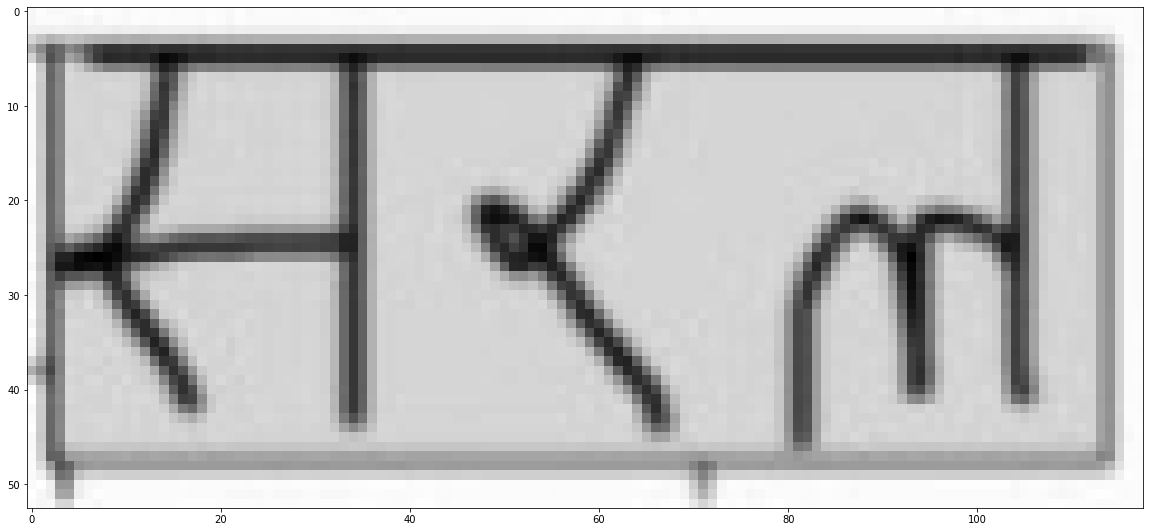

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import warnings
warnings.filterwarnings("ignore")

img = cv2.imread("/content/sample_data/ll.jfif", 0)

def show(img, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.show()
show(img)

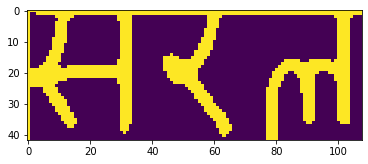

In [ ]:
def borders(here_img, thresh, bthresh=0.092):
    shape = here_img.shape
    #check = int(115 * size[0] / 600)
    #check = int(55 * size[0] / 600)
    check= int(bthresh*shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1
    #plt.imshow(image)
    #plt.show()
    

    #find the background color for empty column
    bg = np.repeat(thresh, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if  (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break
    

    bg = np.repeat(thresh, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if  (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0 
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if(d):
        b = 2
    else:
        b = 0
    
    return (top, bottom, b)


def preprocess(bgr_img):#gray image   
    blur = cv2.GaussianBlur(bgr_img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0
    
    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]
    
    plt.imshow(template)
    plt.show()
    return (template, tb, lr)
prepimg, tb, lr = preprocess(img)

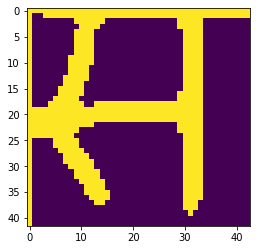

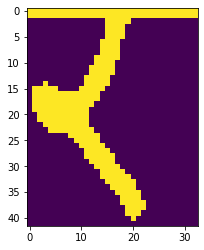

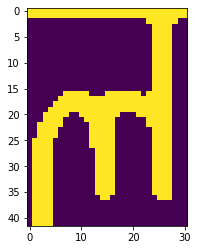

In [ ]:
def segmentation(bordered, thresh=255, min_seg=10, scheck=0.15):
    try:
        shape = bordered.shape
        check = int(scheck * shape[0])
        image = bordered[:]
        image = image[check:].T
        shape = image.shape
        #plt.imshow(image)
        #plt.show()

        #find the background color for empty column
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).all()):
                bg_keys.append(row)            

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[1], bg_keys[-1]]
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                #print(i)

        new_keys = sorted(new_keys)
        #print(new_keys)
        segmented_templates = []
        first = 0
        bounding_boxes = []
        for key in new_keys[1:]:
            segment = bordered.T[first:key]
            if segment.shape[0]>=min_seg and segment.shape[1]>=min_seg:
                segmented_templates.append(segment.T)
                bounding_boxes.append((first, key))
            first = key
        
        last_segment = bordered.T[new_keys[-1]:]
        if last_segment.shape[0]>=min_seg and last_segment.shape[1]>=min_seg:
            segmented_templates.append(last_segment.T)
            bounding_boxes.append((new_keys[-1], new_keys[-1]+last_segment.shape[0]))


        return(segmented_templates, bounding_boxes)
    except:
        return [bordered, (0, bordered.shape[1])]
segments=segmentation(prepimg)
for simg in segments[0]:
    plt.imshow(simg)
    plt.show()

[(-3, 55, 0, 43), (-3, 55, 43, 76), (-3, 55, 76, 107)]


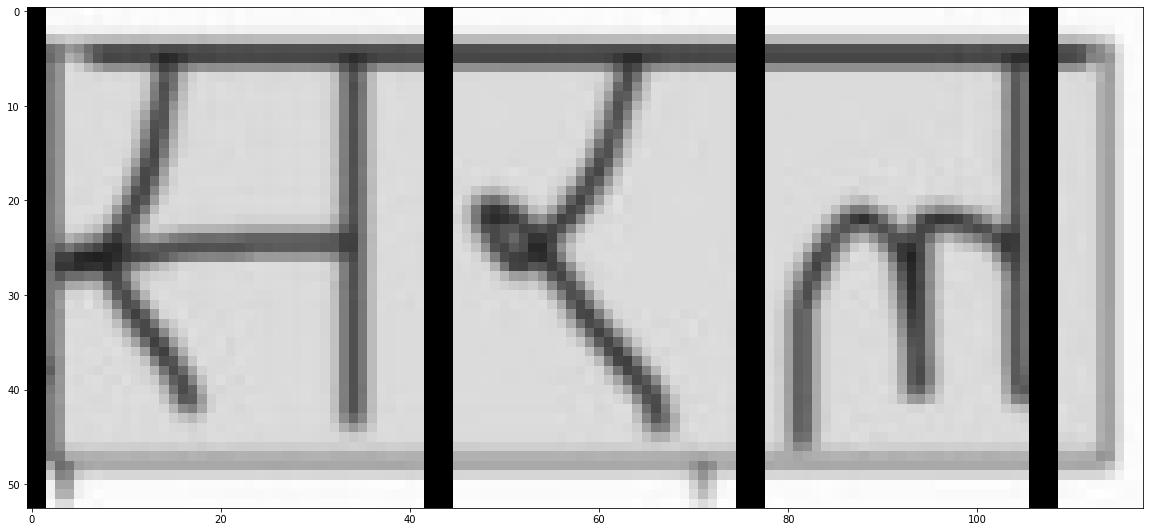

In [ ]:
def localize(orig_img, tb, lr, segments):
    d=5
    rimg = orig_img.copy()
    boxes = []
    for simg, bb in zip(segments[0], segments[1]):
        bb = np.array(bb)
        bb += lr[0]
        # draw rows
        rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
        rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

        # draw cols
        rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
        rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0
        
        boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
        #show(rimg)
    rimg = img.copy()
    print(boxes)
    for box in boxes:
        t, b, l, r = box
        cv2.rectangle(rimg, (l, t), (r, b), (0, 0, 0), 2)
    show(rimg)    
    return rimg, boxes
localized = localize(img, tb, lr, segments)